In [212]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import japanize_matplotlib

In [216]:

spy = "../data/spy.csv"
usdjpy = "../data/usdjpy.csv"
n225 = "../data/n225.csv"


In [266]:
# investingcom から取得した月次データをDataframeへ変換
def to_df(f):
    df = pd.read_csv(f, header=[0])
    df = df.drop(["出来高","変化率 %"], axis=1)

    df["日付け"] = pd.to_datetime(df["日付け"])
    df.set_index("日付け", inplace=True)
    df = df.sort_index()
    try:
        df = df.applymap(lambda x: pd.to_numeric(x))
    except ValueError:
        df = df.applymap(lambda x: x.replace(",", "")).applymap(pd.to_numeric)
    
    return df 


In [267]:
df_spy = to_df(spy)
df_usdjpy = to_df(usdjpy)
df_jpy = df_usdjpy.applymap(lambda x: 1)

df_n225 = to_df(n225)



In [220]:
# simulation 

def sim(df, df_fx, unit, cost):
    # unit = 30000
    # cost = 0.75/100

    df = df.merge(df_fx["終値"], on="日付け", suffixes=["","_fx"], how="left")
    df["基準価額"] = df["終値"] * df["終値_fx"] 
    df["購入口数"] = unit / df["基準価額"] 
    df["総保有口数"] = df["購入口数"].cumsum()
    df["資産評価額"] = df["基準価額"] * df["総保有口数"] 
    df["投資元本"] = [unit * (1 - cost)] * len(df)
    df["投資元本"] = df["投資元本"].cumsum()    
    df["損益"] = df["資産評価額"] - df["投資元本"]
    df["損益%"] = df["資産評価額"] / df["投資元本"] 

    return df 



In [177]:
df_sim = sim(df_spy, df_usdjpy, 30000, 0.75/100)


<AxesSubplot: xlabel='日付け'>

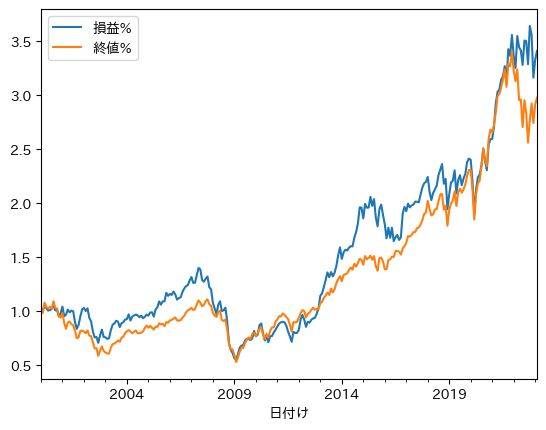

In [178]:
df_sim["損益%"].plot(legend=True)
df_sim["終値%"] = df_sim["終値"].pct_change() + 1
df_sim["終値%"].cumprod().plot(legend=True) 

In [207]:
results = list()
for dt in df_spy.index[:-120].to_series().sample(frac=1):
    _df = df_spy.loc[dt:].head(12*10)
    _df = sim(_df, df_usdjpy, 50000, 0.75/100)
    results.append({"start": dt, "end": _df.index[-1], "pl": _df["損益%"][-1]})
pd.DataFrame(results)["pl"].plot.hist(grid=True)

<AxesSubplot: >

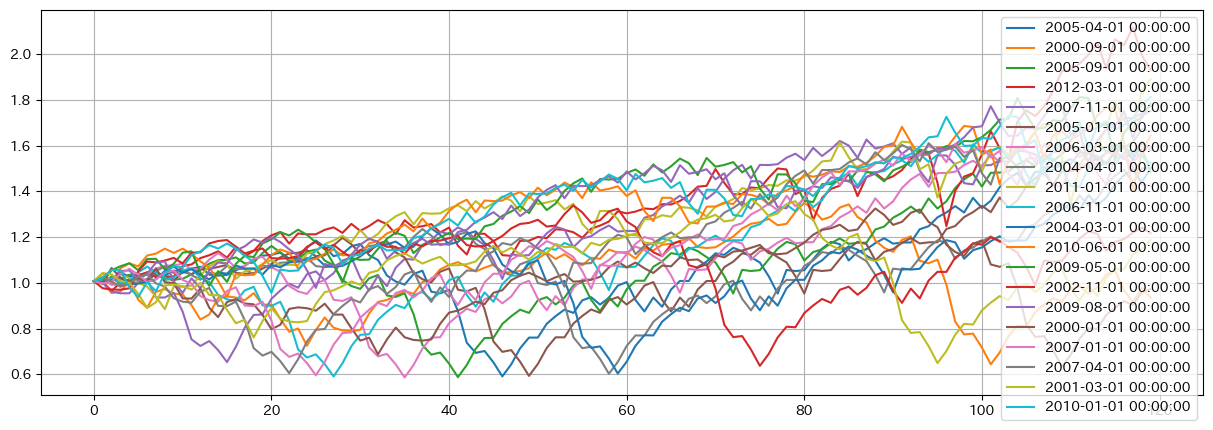

In [313]:
results = list()
for dt in df_spy.index[:-120].to_series().sample(frac=1)[:20]:
    _df = df_spy.loc[dt:].head(12*10)
    _df = sim(_df, df_jpy, 50000, 0.75/100)
    s = pd.Series(_df["損益%"].to_list())
    s.name = dt
    results.append(s)
    
pd.DataFrame(results).T.plot(figsize=(15, 5), legend=True, grid=True)

<AxesSubplot: >

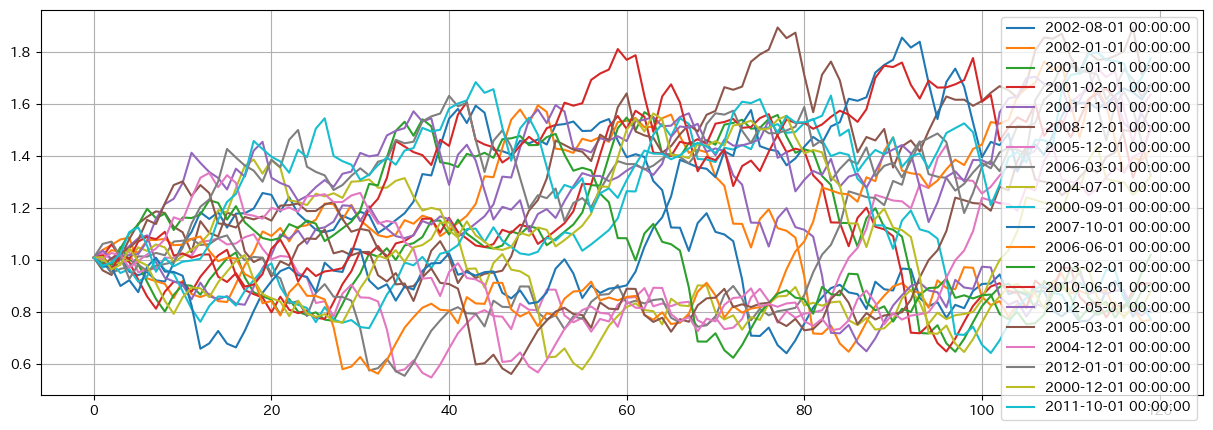

In [309]:
results = list()
for dt in df_n225.index[:-120].to_series().sample(frac=1)[:20]:
    _df = df_n225.loc[dt:].head(12*10)
    _df = sim(_df, df_jpy, 50000, 0.75/100)
    s = pd.Series(_df["損益%"].to_list())
    s.name = dt
    results.append(s)
    
pd.DataFrame(results).T.plot(figsize=(15, 5), legend=True, grid=True)